### Distributed data analysis basics

1. Computing framework: Spark, Hadoop MapReduce
2. Database: MongoDB, SQL, HDFS, Cassandra, Hbase
3. Nodes: single machine, multiple nodes on VMs
4. Dataset: Titanic dataset for inital step

### Part1 - Run on single machine with Spark, MongoDB

In [38]:
# from pyspark.sql.types import *
import pandas as pd
# import pprint
from spark_obj import SparkMongoDB, SparkLocal
import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

In [14]:
dbname = 'titanic'
f_train = 'data/train.csv'
f_test = 'data/test.csv'
numeric_fields = ['Survived', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare']
text_fields = ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

db = utils.get_or_create_db(dbname, drop_on_exist=True)

#### Define datatype for each column, so that the correct types can be read in when using csv reader

In [4]:
# PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
col_types_train = [str, int, int, str, str, float, int, int, str, float, str, str]
# PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
col_types_test = [str, int, str, str, float, int, int, str, float, str, str]

In [5]:
def load_all_data(db, coll_name):
    # read all items from collection 'train', which is a list of dictionaries
    train_docs = utils.read_from_collection(db, coll_name)

    spark = SparkLocal()
    df = spark.create_dataframe(train_docs)
    return spark, df

def load_with_mongodb_connector(dbname, coll_name):
    spark = SparkMongoDB(dbname, coll_name)
    df = spark.create_dataframe()
    return spark, df

#### Save dataset read from csv files into MongoDB:
- database name: 'titanic'
- collections: 'train', 'test'

In [6]:
utils.insert_to_collection(db, 'train', utils.read_from_csvfile(f_train, col_types_train))
utils.insert_to_collection(db, 'test', utils.read_from_csvfile(f_test, col_types_test))

#### Verify data in database

In [7]:
print "Total docs in colection 'train': {}".format(db.train.count())
train_doc = db.train.find_one()
print "The first doc:\n{}".format(train_doc)

Total docs in colection 'train': 891
The first doc:
{u'Fare': 7.25, u'Name': u'Braund, Mr. Owen Harris', u'Embarked': u'S', u'Age': 22.0, u'Parch': 0, u'Pclass': 3, u'Sex': u'male', u'Survived': 0, u'SibSp': 1, u'_id': ObjectId('590e97b0201f21473f1588e0'), u'PassengerId': u'1', u'Ticket': u'A/5 21171', u'Cabin': None}


In [8]:
print "Total docs in colection 'test': {}".format(db.test.count())
test_doc = db.test.find_one()
print "The first doc:\n{}".format(test_doc)

Total docs in colection 'test': 418
The first doc:
{u'Fare': 7.8292, u'Name': u'Kelly, Mr. James', u'Embarked': u'Q', u'Age': 34.5, u'Parch': 0, u'Pclass': 3, u'Sex': u'male', u'SibSp': 0, u'_id': ObjectId('590e97b0201f21473f158c5b'), u'PassengerId': u'892', u'Ticket': u'330911', u'Cabin': None}


#### Read the whole training data from MongoDB, and create a sparkSession and a pyspark dataframe

In [9]:
coll_name = 'train'
# spark-submit run.py
spark, df = load_all_data(db, coll_name)
print df.count()

891


#### Create pyspark dataframe with the data

In [10]:
df.printSchema()

root
 |-- Age: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- Parch: long (nullable = true)
 |-- PassengerId: string (nullable = true)
 |-- Pclass: long (nullable = true)
 |-- Sex: string (nullable = true)
 |-- SibSp: long (nullable = true)
 |-- Survived: long (nullable = true)
 |-- Ticket: string (nullable = true)



In [11]:
df.take(2)

[Row(Age=22.0, Cabin=None, Embarked=u'S', Fare=7.25, Name=u'Braund, Mr. Owen Harris', Parch=0, PassengerId=u'1', Pclass=3, Sex=u'male', SibSp=1, Survived=0, Ticket=u'A/5 21171'),
 Row(Age=38.0, Cabin=u'C85', Embarked=u'C', Fare=71.2833, Name=u'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Parch=0, PassengerId=u'2', Pclass=1, Sex=u'female', SibSp=1, Survived=1, Ticket=u'PC 17599')]

#### Print the stats for only numeric columns

In [12]:
df.toPandas().describe()

,Age,Fare,Parch,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,3.000000,8.000000,1.000000


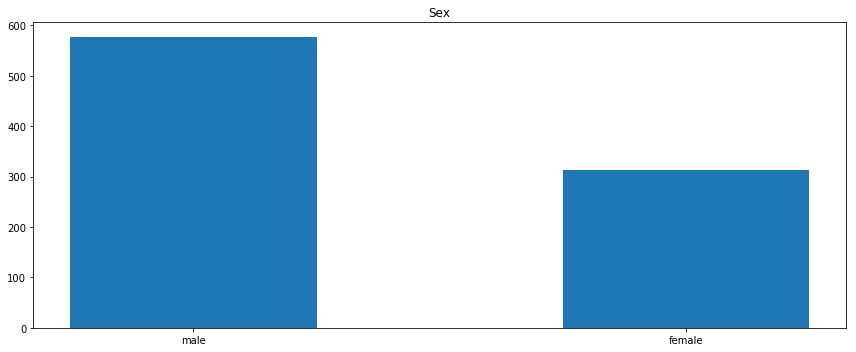

In [37]:
utils.get_histogram(df, "Sex", bins=10)

In [32]:
df.dtypes

[('Age', 'double'),
 ('Cabin', 'string'),
 ('Embarked', 'string'),
 ('Fare', 'double'),
 ('Name', 'string'),
 ('Parch', 'bigint'),
 ('PassengerId', 'string'),
 ('Pclass', 'bigint'),
 ('Sex', 'string'),
 ('SibSp', 'bigint'),
 ('Survived', 'bigint'),
 ('Ticket', 'string')]

#### Get summary statistics for both numeric and text fields
The dataset is not cleaned, so the results are a bit messive here.

In [12]:
stats_text = spark.get_stats_summary_text_fields(df, text_fields)
utils.pretty_print_stats(stats_text)


Field: Fare
{'max': 512.3292, 'mean': 32.20420796857464, 'median': 14.4583, 'min': 0.0}

Field: SibSp
{'max': 8, 'mean': 0.5230078563411896, 'median': 0.0, 'min': 0}

Field: Survived
{'max': 1, 'mean': 0.3838383838383838, 'median': 0.0, 'min': 0}

Field: Age
{'max': 80.0, 'mean': 29.69911764705882, 'median': 27.0, 'min': 0.42}

Field: Parch
{'max': 6, 'mean': 0.38159371492704824, 'median': 0.0, 'min': 0}

Field: Pclass
{'max': 3, 'mean': 2.308641975308642, 'median': 3.0, 'min': 1}

Field: Ticket
{'max': (u'PC', 60),
 'min': (u'3101317', 1),
 'unique_count': 723,
 'word_counts': [(u'PC', 60),
                 (u'C.A.', 27),
                 (u'2.', 12),
                 (u'STON/O', 12),
                 (u'A/5', 10),
                 (u'W./C.', 9),
                 (u'SOTON/O.Q.', 8),
                 (u'CA.', 8),
                 (u'SOTON/OQ', 7),
                 (u'347082', 7),
                 '...',
                 (u'39886', 1),
                 (u'3536', 1),
                 (u

#### Print correlation matrix for numeric columns

In [13]:
corr_matrix = spark.get_correlation_matrix(df, numeric_fields)
df_corr = utils.create_pandas_dataframe(corr_matrix, numeric_fields, numeric_fields)
print df_corr

          Survived       Age    Pclass     SibSp     Parch      Fare
Survived  1.000000  0.010539 -0.338481 -0.035322  0.081629  0.257307
Age       0.010539  1.000000 -0.361353 -0.184664 -0.048786  0.135516
Pclass   -0.338481 -0.361353  1.000000  0.083081  0.018443 -0.549500
SibSp    -0.035322 -0.184664  0.083081  1.000000  0.414838  0.159651
Parch     0.081629 -0.048786  0.018443  0.414838  1.000000  0.216225
Fare      0.257307  0.135516 -0.549500  0.159651  0.216225  1.000000


#### Print covariance matrix for numeric columns

In [14]:
cov_matrix = spark.get_covariance_matrix(df, numeric_fields)
df_cov = utils.create_pandas_dataframe(cov_matrix, numeric_fields, numeric_fields)
print df_cov

          Survived         Age     Pclass     SibSp     Parch        Fare
Survived  1.000000    0.090238  -0.137703 -0.018954  0.032017    6.221787
Age       0.090238    1.000000  -5.316074 -3.583203 -0.691955  118.496316
Pclass   -0.137703   -5.316074   1.000000  0.076599  0.012429  -22.830196
SibSp    -0.018954   -3.583203   0.076599  1.000000  0.368739    8.748734
Parch     0.032017   -0.691955   0.012429  0.368739  1.000000    8.661052
Fare      6.221787  118.496316 -22.830196  8.748734  8.661052    1.000000


In [29]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")